In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.labels = data[:, 0]                                     # (n, 1)
        self.pixels = data[:, 1:].reshape(data.shape[0], 1, 28, 28)  # (n, 1, 28, 28)
        self.transform = transform
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return (self.pixels[idx], self.labels[idx])

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.75, 1), shear=30),
    transforms.Normalize(0, 255)
])

val_transforms = transforms.Compose([
    transforms.Normalize(0, 255)
])

In [5]:
dataset = pd.read_csv('../train.csv').values
train_data, val_data = train_test_split(dataset, test_size=0.2)
train_set = MNISTDataset(train_data, transform=train_transforms)
val_set = MNISTDataset(val_data, transform=val_transforms)
print(len(train_set))
print(len(val_set))

33600
8400


In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = F.avg_pool2d(x, 2)
        x = torch.sigmoid(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = F.softmax(x, dim=1)
        return output
    
    def loss(self, output, label):
        loss = F.cross_entropy(output, label)
        return loss

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    print("Epoch %d" % epoch)
    model.train()
    losses = []
    
    # iterate through batches
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device = device, dtype = torch.float)
        label = label.to(device = device, dtype = torch.long)

        # forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # print loss every 21 batch iterations
        if i % 21 == 0:
            print("Batch Iteration %d, Train Loss: %.6f" % (i, loss.item()))
    
    return losses


def validate(model, device, val_loader):
    model.eval()
    losses = []
    
    correct = 0
    with torch.no_grad():
        for (data, label) in val_loader:
            data = data.to(device = device, dtype = torch.float)
            label = label.to(device = device, dtype = torch.long)
            output = model(data)
            loss = model.loss(output, label)
            losses.append(loss.item())
            
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
    val_loss = np.mean(losses)

    print("\nValidation Loss: {}, Accuracy: {}/{} ({:.0f}%)\n".format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return losses, val_loss

Using: cuda
Epoch 1
Batch Iteration 0, Train Loss: 2.302686
Batch Iteration 21, Train Loss: 2.300240
Batch Iteration 42, Train Loss: 2.298223
Batch Iteration 63, Train Loss: 2.303801
Batch Iteration 84, Train Loss: 2.300340
Batch Iteration 105, Train Loss: 2.298844
Batch Iteration 126, Train Loss: 2.301507
Batch Iteration 147, Train Loss: 2.296229

Validation Loss: 2.2927706227416085, Accuracy: 979/8400 (12%)

Epoch 2
Batch Iteration 0, Train Loss: 2.290710
Batch Iteration 21, Train Loss: 2.275035
Batch Iteration 42, Train Loss: 2.175604
Batch Iteration 63, Train Loss: 2.102944
Batch Iteration 84, Train Loss: 1.926192
Batch Iteration 105, Train Loss: 1.823398
Batch Iteration 126, Train Loss: 1.764542
Batch Iteration 147, Train Loss: 1.735679

Validation Loss: 1.689937487954185, Accuracy: 6575/8400 (78%)

Epoch 3
Batch Iteration 0, Train Loss: 1.695371
Batch Iteration 21, Train Loss: 1.664338
Batch Iteration 42, Train Loss: 1.675257
Batch Iteration 63, Train Loss: 1.652160
Batch Iterati

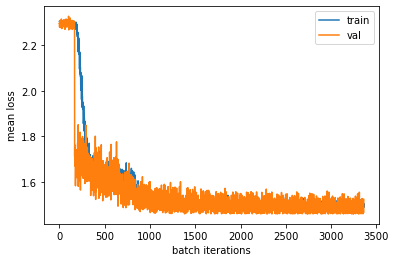

In [8]:
# hyperparameters
TRAIN_BATCH_SIZE = 200
VAL_BATCH_SIZE = 50
EPOCHS = 20

# hardware device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: %s" % device)
kwargs = {'num_workers': 0,
          'pin_memory': True} if use_cuda else {}

# data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = TRAIN_BATCH_SIZE,
                                           shuffle = True, drop_last = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = VAL_BATCH_SIZE,
                                         shuffle = False, drop_last = True, **kwargs)  

# training objects
model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training loop
train_curve = []
val_curve = []
best_loss = np.inf
for epoch in range(1, EPOCHS + 1):
    train_losses = train(model, device, train_loader, optimizer, epoch)
    val_losses, val_loss = validate(model, device, val_loader)
    train_curve.extend(train_losses)
    val_curve.extend(val_losses)
    
    scheduler.step()
    
    # save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/epoch_%d.pt" % epoch)
        
# plot loss functions
plt.plot(np.arange(EPOCHS * 168) + 1, train_curve, label = "train")
plt.plot(np.arange(EPOCHS * 168) + 1, val_curve, label = "val")
plt.legend()
plt.xlabel('batch iterations')
plt.ylabel('mean loss')
plt.show()